In [10]:
!pip -q install requests rasterio numpy xarray netcdf4 pillow matplotlib shapely


In [24]:
import os, math, json, calendar
import numpy as np
import xarray as xr
import requests

from datetime import datetime
from io import BytesIO
from PIL import Image
from rasterio.io import MemoryFile
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from matplotlib.path import Path  # fast point-in-polygon

#CDSE official endpoints
TOKEN_URL   = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
PROCESS_URL = "https://sh.dataspace.copernicus.eu/api/v1/process"

#OAuth credentials
os.environ.setdefault("CDSE_CLIENT_ID", "proxy_token")
os.environ.setdefault("CDSE_CLIENT_SECRET", "proxy_token")

# Soil moisture NetCDF
SM_NC = "/content/C3S-SOILMOISTURE-L3S-SSMV-COMBINED-DEKADAL-20260111000000-ICDR-v202505.0.0.nc"

#polygon points: (lat, lon)
points = [
    (31.604017, -105.432963),
    (31.602521, -105.459541),
    (31.591777, -105.460123),
    (31.582210, -105.432958),
]

print("Soil file exists:", os.path.exists(SM_NC))


Soil file exists: True


In [25]:
def cdse_token() -> str:
    r = requests.post(
        TOKEN_URL,
        data={
            "grant_type": "client_credentials",
            "client_id": os.environ["CDSE_CLIENT_ID"].strip(),
            "client_secret": os.environ["CDSE_CLIENT_SECRET"].strip(),
        },
        timeout=60,
    )
    r.raise_for_status()
    return r.json()["access_token"]

def cdse_headers():
    tok = cdse_token()
    return {"Authorization": f"Bearer {tok}", "Content-Type": "application/json"}

def process_api(body: dict, timeout=180) -> bytes:
    hdrs = cdse_headers()
    r = requests.post(PROCESS_URL, headers=hdrs, json=body, timeout=timeout)
    r.raise_for_status()
    return r.content

def tiff_to_array_1band(tiff_bytes: bytes) -> np.ndarray:
    with MemoryFile(tiff_bytes) as mem:
        with mem.open() as ds:
            return ds.read(1).astype(np.float32)


In [26]:
def bbox_from_points(points_latlon):
    lats = [p[0] for p in points_latlon]
    lons = [p[1] for p in points_latlon]
    return [min(lons), min(lats), max(lons), max(lats)]  # [minLon,minLat,maxLon,maxLat]

def centroid_from_points(points_latlon):
    lats = [p[0] for p in points_latlon]
    lons = [p[1] for p in points_latlon]
    return float(np.median(lats)), float(np.median(lons))  # (lat, lon)

def moisture_latest(lat, lon, nc_file=SM_NC):
    nc_file = os.path.expanduser(nc_file)
    if not os.path.exists(nc_file):
        raise FileNotFoundError(f"NetCDF not found: {nc_file}")

    ds = xr.open_dataset(nc_file)
    try:
        v = ds["sm"].sel(lat=lat, lon=lon, method="nearest").isel(time=-1)
        return {
            "sm": float(np.array(v.values).squeeze()),
            "time": str(v["time"].values),
            "lat_used": float(v["lat"].values),
            "lon_used": float(v["lon"].values),
            "source": "Copernicus CDS soil moisture (NetCDF)"
        }
    finally:
        ds.close()

def ndvi_median_over_bbox(bbox, date_from="2025-06-01", date_to="2025-06-30", cloud=30, width=128, height=128):
    body = {
        "input": {
            "bounds": {"bbox": bbox, "properties": {"crs":"http://www.opengis.net/def/crs/OGC/1.3/CRS84"}},
            "data": [{
                "type": "sentinel-2-l2a",
                "dataFilter": {
                    "timeRange": {"from": date_from+"T00:00:00Z", "to": date_to+"T23:59:59Z"},
                    "maxCloudCoverage": cloud
                },
                "processing": {"mosaickingOrder":"leastCloudy"}
            }]
        },
        "output": {"width": width, "height": height,
                   "responses": [{"identifier":"default","format":{"type":"image/tiff"}}]},
        "evalscript": """
        //VERSION=3
        function setup() {
          return {
            input: [{bands:["B04","B08","dataMask"], units:"REFLECTANCE"}],
            output: {bands:1, sampleType:"FLOAT32"}
          };
        }
        function evaluatePixel(s) {
          if (s.dataMask === 0) return [NaN];
          var ndvi = (s.B08 - s.B04) / (s.B08 + s.B04 + 1e-6);
          return [ndvi];
        }
        """
    }

    grid = tiff_to_array_1band(process_api(body, timeout=180))
    valid_frac = float(np.isfinite(grid).mean())
    med = float(np.nanmedian(grid)) if valid_frac > 0 else float("nan")
    if valid_frac < 0.2:
        med = float("nan")

    return {"ndvi_median": med, "valid_frac": valid_frac}

def dem_and_slope_median_over_bbox(bbox, width=128, height=128):
    body = {
        "input": {
            "bounds": {"bbox": bbox, "properties":{"crs":"http://www.opengis.net/def/crs/OGC/1.3/CRS84"}},
            "data": [{"type":"dem", "dataFilter":{"demInstance":"COPERNICUS_30"}}]
        },
        "output": {"width": width, "height": height,
                   "responses": [{"identifier":"default","format":{"type":"image/tiff"}}]},
        "evalscript": """
        //VERSION=3
        function setup() { return { input:["DEM"], output:{bands:1, sampleType:"FLOAT32"} }; }
        function evaluatePixel(s) { return [s.DEM]; }
        """
    }

    dem = tiff_to_array_1band(process_api(body, timeout=180))
    elev_med = float(np.nanmedian(dem))

    minLon, minLat, maxLon, maxLat = bbox
    lat0 = (minLat + maxLat) / 2.0
    m_per_deg_lat = 111_320.0
    m_per_deg_lon = 111_320.0 * np.cos(np.deg2rad(lat0))

    width_m  = (maxLon - minLon) * m_per_deg_lon
    height_m = (maxLat - minLat) * m_per_deg_lat
    px = width_m  / max(dem.shape[1]-1, 1)
    py = height_m / max(dem.shape[0]-1, 1)

    dzdy, dzdx = np.gradient(dem, py, px)
    slope = np.degrees(np.arctan(np.sqrt(dzdx**2 + dzdy**2)))

    return {
        "elevation_median_m": elev_med,
        "slope_median_deg": float(np.nanmedian(slope)),
    }

def irradiance_nasa_power_kwh_m2_year(lat, lon, years_back=10):
    today = datetime.utcnow()
    latest_year = today.year - 1
    start_year = latest_year - years_back + 1

    url = (
        "https://power.larc.nasa.gov/api/temporal/monthly/point"
        f"?parameters=ALLSKY_SFC_SW_DWN"
        f"&community=RE"
        f"&longitude={lon}&latitude={lat}"
        f"&start={start_year}&end={latest_year}"
        "&format=JSON"
    )
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    data = r.json()

    series = data["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"]

    def yearly_total(y):
        total = 0.0
        for m in range(1, 13):
            key = f"{y}{m:02d}"
            if key not in series:
                continue
            v = float(series[key])  # kWh/m^2/day (monthly mean daily)
            if v < 0:
                continue
            days = calendar.monthrange(y, m)[1]
            total += v * days
        return total

    vals = [yearly_total(y) for y in range(start_year, latest_year+1)]
    return {
        "latest_year": latest_year,
        "kwh_m2_year": float(vals[-1]),
        "multi_year_avg": float(sum(vals)/len(vals)),
        "source": "NASA POWER (ALLSKY_SFC_SW_DWN)"
    }


In [27]:
def summarize_region(points_latlon, s2_from="2025-06-01", s2_to="2025-06-30", sm_nc_file=SM_NC):
    bbox = bbox_from_points(points_latlon)
    lat_c, lon_c = centroid_from_points(points_latlon)

    ndvi = ndvi_median_over_bbox(bbox, s2_from, s2_to)
    dem  = dem_and_slope_median_over_bbox(bbox)
    sm   = moisture_latest(lat_c, lon_c, sm_nc_file)
    irr  = irradiance_nasa_power_kwh_m2_year(lat_c, lon_c)

    print("Centroid (lat,lon):", lat_c, lon_c)
    print("NDVI median:", ndvi["ndvi_median"], " valid_frac:", ndvi["valid_frac"])
    print("Elevation median (m):", round(dem["elevation_median_m"], 2))
    print("Slope median (deg):", round(dem["slope_median_deg"], 2))
    print("Soil moisture:", round(sm["sm"], 4), " time:", sm["time"])
    print("Irradiance (latest year):", round(irr["kwh_m2_year"], 1), "kWh/m²/yr")
    print("Irradiance (10y avg):", round(irr["multi_year_avg"], 1), "kWh/m²/yr")

    return {"bbox": bbox, "centroid": (lat_c, lon_c), "NDVI": ndvi, "DEM": dem, "SOIL": sm, "IRR": irr}

region = summarize_region(points, s2_from="2025-06-01", s2_to="2025-06-30", sm_nc_file=SM_NC)


/tmp/ipython-input-899170734.py:105: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = datetime.utcnow()


Centroid (lat,lon): 31.597149 -105.446252
NDVI median: 0.07406717538833618  valid_frac: 1.0
Elevation median (m): 1322.88
Slope median (deg): 1.11
Soil moisture: 0.1367  time: 2026-01-11T00:00:00.000000000
Irradiance (latest year): 1722.6 kWh/m²/yr
Irradiance (10y avg): 2091.7 kWh/m²/yr


In [28]:
def clip01(x): return max(0.0, min(1.0, x))

def score_irradiance(I_kwh_m2_yr, I_min=1000.0, I_max=2200.0):
    if I_kwh_m2_yr is None or (isinstance(I_kwh_m2_yr, float) and math.isnan(I_kwh_m2_yr)):
        return float("nan")
    return clip01((I_kwh_m2_yr - I_min) / (I_max - I_min))

def score_slope(slope_deg):
    if slope_deg is None or (isinstance(slope_deg, float) and math.isnan(slope_deg)):
        return float("nan")
    if slope_deg <= 5.0:  return 1.0
    if slope_deg > 5 and slope_deg <= 10.0: return 0.8 - (slope_deg - 5.0) * (0.4/5.0)
    if slope_deg > 10 and slope_deg <= 15.0: return 0.6 - (slope_deg - 10.0) * (0.4/5.0)
    if slope_deg > 15 and slope_deg <= 30.0: return 0.4
    return 0.0

def score_veg_ndvi(ndvi):
    if ndvi is None or (isinstance(ndvi, float) and math.isnan(ndvi)):
        return float("nan")
    if ndvi <= 0.2: return 1.0
    if ndvi >0.2 and ndvi <= 0.6:  return 0.8
    if ndvi > 0.6:  return 0.4
    return 0.1

def score_moisture(sm):
    if sm is None or (isinstance(sm, float) and math.isnan(sm)):
        return float("nan")
    if sm <= 0.2:  return 1.0
    if sm >0.2 and sm <= 0.45: return 0.7
    if sm >0.45: return 0.5
    return 0.5

def score_elevation(elev_m):
    if elev_m is None or (isinstance(elev_m, float) and math.isnan(elev_m)):
        return float("nan")
    if elev_m <= 50.0: return 0.5
    if elev_m >50 and elev_m <= 1000.0: return 1.0
    if elev_m >1000 and elev_m < 2000.0: return 0.7
    if elev_m >2000: return 0.4
    return 0.5

ndvi  = float(region["NDVI"]["ndvi_median"])
elev  = float(region["DEM"]["elevation_median_m"])
slope = float(region["DEM"]["slope_median_deg"])
moist = float(region["SOIL"]["sm"])
I10   = float(region["IRR"]["multi_year_avg"])

SI = score_irradiance(I10)
SS = score_slope(slope)
SV = score_veg_ndvi(ndvi)
SM = score_moisture(moist)
SE = score_elevation(elev)

wI, wS, wV, wM, wE = 0.43, 0.24, 0.18, 0.10, 0.05
final_score = 100.0 * (wI*SI + wS*SS + wV*SV + wM*SM + wE*SE)

print("Inputs:")
print(f"  NDVI median         : {ndvi:.6f}")
print(f"  Elevation (m)       : {elev:.2f}")
print(f"  Slope (deg)         : {slope:.2f}")
print(f"  Soil moisture       : {moist:.4f}")
print(f"  10yr avg irradiance : {I10:.1f} kWh/m²/yr")

print("\nSub-scores (0..1):")
print(f"  SI (irradiance) : {SI:.4f}")
print(f"  SS (slope)      : {SS:.4f}")
print(f"  SV (NDVI/veg)   : {SV:.4f}")
print(f"  SM (moisture)   : {SM:.4f}")
print(f"  SE (elevation)  : {SE:.4f}")

print(f"\nFinal suitability score (0–100): {final_score:.2f}")


Inputs:
  NDVI median         : 0.074067
  Elevation (m)       : 1322.88
  Slope (deg)         : 1.11
  Soil moisture       : 0.1367
  10yr avg irradiance : 2091.7 kWh/m²/yr

Sub-scores (0..1):
  SI (irradiance) : 0.9098
  SS (slope)      : 1.0000
  SV (NDVI/veg)   : 1.0000
  SM (moisture)   : 1.0000
  SE (elevation)  : 0.7000

Final suitability score (0–100): 94.62


sat_img: (1024, 1024, 3) bbox: [-105.46162299999999, 31.58071, -105.431458, 31.605517]


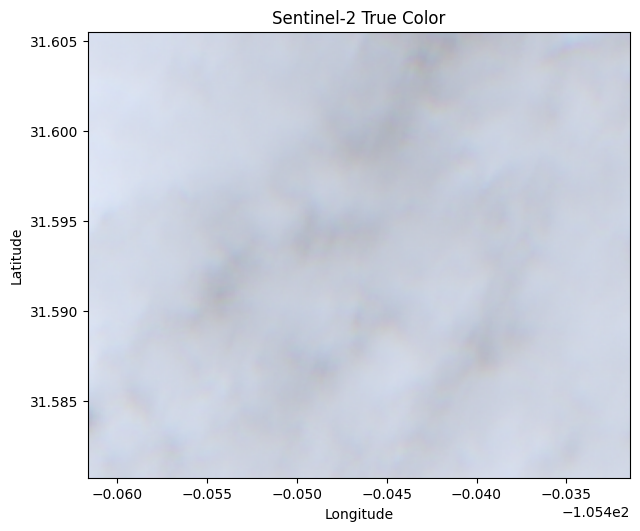

In [29]:
def padded_bbox_from_points(points_latlon, pad_deg=0.0015):
    bbox = bbox_from_points(points_latlon)
    minLon, minLat, maxLon, maxLat = bbox
    return [minLon-pad_deg, minLat-pad_deg, maxLon+pad_deg, maxLat+pad_deg]

bbox_img = padded_bbox_from_points(points, pad_deg=0.0015)
min_lon, min_lat, max_lon, max_lat = bbox_img

evalscript_true = """
//VERSION=3
function setup() {
  return { input: ["B02","B03","B04"], output: { bands: 3, sampleType: "AUTO" } };
}
function evaluatePixel(s) {
  return [s.B04, s.B03, s.B02];
}
"""

payload = {
    "input": {
        "bounds": {"bbox": bbox_img, "properties":{"crs":"http://www.opengis.net/def/crs/OGC/1.3/CRS84"}},
        "data": [{
            "type": "sentinel-2-l2a",
            "dataFilter": {
                "timeRange": {"from": "2025-06-01T00:00:00Z", "to": "2025-06-30T23:59:59Z"},
                "mosaickingOrder": "mostRecent"
            }
        }]
    },
    "output": {
        "width": 1024, "height": 1024,
        "responses": [{"identifier":"default", "format":{"type":"image/png"}}]
    },
    "evalscript": evalscript_true
}

png = process_api(payload, timeout=180)
sat_img = np.array(Image.open(BytesIO(png)).convert("RGB"))
print("sat_img:", sat_img.shape, "bbox:", bbox_img)

plt.figure(figsize=(7,7))
plt.imshow(sat_img, extent=[min_lon, max_lon, min_lat, max_lat], origin="upper")
plt.title("Sentinel-2 True Color")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()


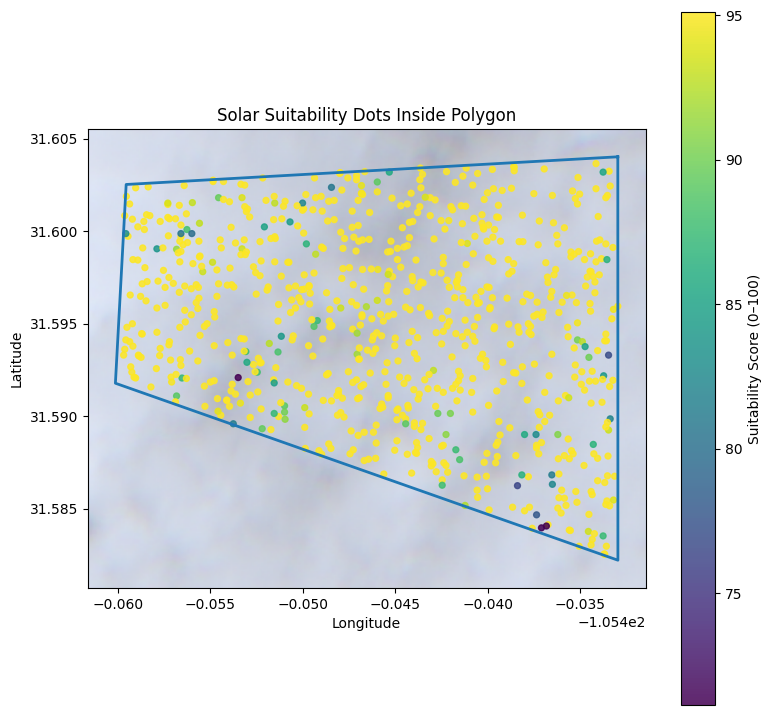

Score stats (sample inside polygon):
  min : 71.11930084228516
  mean: 94.3296890258789
  max : 95.11930084228516


In [30]:
H, W = sat_img.shape[:2]

# NDVI raster (same size as image) ---
evalscript_ndvi = """
//VERSION=3
function setup() { return { input: ["B04","B08"], output: { bands: 1, sampleType: "FLOAT32" } }; }
function evaluatePixel(s) {
  let ndvi = (s.B08 - s.B04) / (s.B08 + s.B04 + 1e-6);
  return [ndvi];
}
"""
payload_ndvi = {
    "input": {
        "bounds": {"bbox": bbox_img, "properties":{"crs":"http://www.opengis.net/def/crs/OGC/1.3/CRS84"}},
        "data": [{
            "type": "sentinel-2-l2a",
            "dataFilter": {"timeRange": {"from":"2025-06-01T00:00:00Z","to":"2025-06-30T23:59:59Z"},
                           "mosaickingOrder":"mostRecent"}
        }]
    },
    "output": {"width": W, "height": H, "responses":[{"identifier":"default","format":{"type":"image/tiff"}}]},
    "evalscript": evalscript_ndvi
}
ndvi_map = tiff_to_array_1band(process_api(payload_ndvi, timeout=180))

# DEM raster (same size as image)
evalscript_dem = """
//VERSION=3
function setup() { return { input: ["DEM"], output: { bands: 1, sampleType: "FLOAT32" } }; }
function evaluatePixel(s) { return [s.DEM]; }
"""
payload_dem = {
    "input": {
        "bounds": {"bbox": bbox_img, "properties":{"crs":"http://www.opengis.net/def/crs/OGC/1.3/CRS84"}},
        "data": [{"type":"dem", "dataFilter":{"demInstance":"COPERNICUS_30"}}]
    },
    "output": {"width": W, "height": H, "responses":[{"identifier":"default","format":{"type":"image/tiff"}}]},
    "evalscript": evalscript_dem
}
dem_map = tiff_to_array_1band(process_api(payload_dem, timeout=180))

#slope map from DEM
lat0 = (min_lat + max_lat)/2.0
m_per_deg_lat = 111_320.0
m_per_deg_lon = 111_320.0 * np.cos(np.deg2rad(lat0))

dx_m = (max_lon - min_lon) * m_per_deg_lon / max(W-1, 1)
dy_m = (max_lat - min_lat) * m_per_deg_lat / max(H-1, 1)

gy, gx = np.gradient(dem_map, dy_m, dx_m)
slope_deg_map = np.degrees(np.arctan(np.sqrt(gx*gx + gy*gy)))

#scoring maps
def score_ndvi_map(ndvi):
    sv = np.full_like(ndvi, 0.1, dtype=np.float32)
    sv[ndvi <= 0.1] = 1.0
    sv[(ndvi > 0.1) & (ndvi < 0.5)] = 0.7
    sv[(ndvi >= 0.5) & (ndvi < 0.6)] = 0.4
    return sv

def score_slope_map(slope):
    ss = np.zeros_like(slope, dtype=np.float32)
    m1 = slope <= 5.0
    ss[m1] = 1.0
    m2 = (slope > 5.0) & (slope <= 10.0)
    ss[m2] = 1.0 - (slope[m2] - 5.0) * (0.4/5.0)
    m3 = (slope > 10.0) & (slope <= 15.0)
    ss[m3] = 0.6 - (slope[m3] - 10.0) * (0.4/5.0)
    return ss

def score_elev_map(elev):
    se = np.full_like(elev, 0.5, dtype=np.float32)
    se[(elev > 50.0) & (elev <= 1000.0)] = 1.0
    se[(elev > 1000.0) & (elev <= 2000.0)] = 0.8
    se[elev <= 50.0] = 0.5
    se[elev > 2000.0] = 0.5
    return se

SV = score_ndvi_map(ndvi_map)
SS = score_slope_map(slope_deg_map)
SE = score_elev_map(dem_map)

SI_const = np.float32(score_irradiance(I10))
SM_const = np.float32(score_moisture(moist))

SI = np.full((H, W), SI_const, dtype=np.float32)
SMm = np.full((H, W), SM_const, dtype=np.float32)

wI, wS, wV, wM, wE = 0.43, 0.24, 0.18, 0.10, 0.05
score_map = 100.0 * (wI*SI + wS*SS + wV*SV + wM*SMm + wE*SE)

# fast polygon mask using matplotlib.path
poly_lonlat = np.array([(lon, lat) for (lat, lon) in points] + [(points[0][1], points[0][0])])
poly_path = Path(poly_lonlat)

xs = np.linspace(min_lon, max_lon, W)
ys = np.linspace(max_lat, min_lat, H)  # top to bottom
xx, yy = np.meshgrid(xs, ys)

pts = np.vstack([xx.ravel(), yy.ravel()]).T
mask_inside = poly_path.contains_points(pts).reshape(H, W)

inside_idx = np.argwhere(mask_inside)
if len(inside_idx) == 0:
    raise RuntimeError("No pixels inside polygon. Increase pad_deg or check point order.")

# sample dots
N = min(800, len(inside_idx))
sel = inside_idx[np.random.choice(len(inside_idx), size=N, replace=False)]
si, sj = sel[:,0], sel[:,1]

sel_lon = xx[si, sj]
sel_lat = yy[si, sj]
sel_score = score_map[si, sj]

# plot
plt.figure(figsize=(9, 9))
plt.imshow(sat_img, extent=[min_lon, max_lon, min_lat, max_lat], origin="upper")
plt.plot(poly_lonlat[:,0], poly_lonlat[:,1], linewidth=2)

sc = plt.scatter(sel_lon, sel_lat, c=sel_score, s=18, alpha=0.85)
plt.colorbar(sc, label="Suitability Score (0–100)")

plt.title("Solar Suitability Dots Inside Polygon")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()

print("Score stats (sample inside polygon):")
print("  min :", float(np.min(sel_score)))
print("  mean:", float(np.mean(sel_score)))
print("  max :", float(np.max(sel_score)))
